In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
import joblib
import matplotlib.pyplot as plt
import pandas as pd

random_state = 42

In [25]:
def read_dataset(path, sep=';', encoding='utf-8-sig', low_memory=False):
    return pd.read_csv(path, sep=sep, encoding=encoding, low_memory=low_memory)

course_1_bak_spec = read_dataset("../../data/datasets/1st_course_bak_spec.csv")
course_1_magistr = read_dataset("../../data/datasets/1st_course_magistr.csv")

subjects_bak_spec = read_dataset("../../data/datasets/subjects_bak_spec.csv")
subjects_magistr = read_dataset("../../data/datasets/subjects_magistr.csv")

In [26]:
X_c1_bak_spec = course_1_bak_spec.drop(columns=["Таргет"])
y_c1_bak_spec = course_1_bak_spec["Таргет"]

X_train_c1_bak_spec, X_test_c1_bak_spec, y_train_c1_bak_spec, y_test_c1_bak_spec = train_test_split(
    X_c1_bak_spec,
    y_c1_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_c1_magistr = course_1_magistr.drop(columns=["Таргет"])
y_c1_magistr = course_1_magistr["Таргет"]

X_train_c1_magistr, X_test_c1_magistr, y_train_c1_magistr, y_test_c1_magistr = train_test_split(
    X_c1_magistr,
    y_c1_magistr,
    test_size=0.2,
    random_state=random_state
)

X_s_bak_spec = subjects_bak_spec.drop(columns=["Таргет"])
y_s_bak_spec = subjects_bak_spec["Таргет"]

X_train_s_bak_spec, X_test_s_bak_spec, y_train_s_bak_spec, y_test_s_bak_spec = train_test_split(
    X_s_bak_spec,
    y_s_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_s_magistr = subjects_magistr.drop(columns=["Таргет"])
y_s_magistr = subjects_magistr["Таргет"]

X_train_s_magistr, X_test_s_magistr, y_train_s_magistr, y_test_s_magistr = train_test_split(
    X_s_magistr,
    y_s_magistr,
    test_size=0.2,
    random_state=random_state
)

In [27]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train_s_magistr)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_s_magistr)
class_weights = [weights[0], weights[1]]

Лучшие параметры: {'clf': <catboost.core.CatBoostClassifier object at 0x000001EEF46EBCA0>, 'clf__class_weights': [np.float64(0.589010989010989), np.float64(3.308641975308642)], 'clf__depth': 4, 'clf__l2_leaf_reg': 1, 'clf__learning_rate': 0.1, 'clf__min_data_in_leaf': 1, 'clf__n_estimators': 100}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x000001EEF4616B90>)])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.96      0.84      0.89       117
           1       0.41      0.76      0.53        17

    accuracy                           0.83       134
   macro avg       0.68      0.80      0.71       134
weighted avg       0.89      0.83      0.85       134



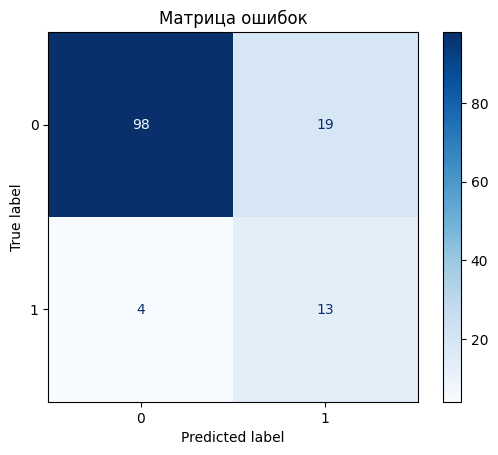


Feature Importances:
                                            feature  importance
37                      Позиция студента в рейтинге   31.527031
9                           Общее количество долгов   15.438792
1                            Cумма баллов испытаний   10.852219
7                  Полных лет на момент поступления    9.257616
0                                         Приоритет    6.283870
3                                          Контракт    5.078878
11                             fromSverdlovskRegion    3.674109
2                           Балл за инд. достижения    2.692594
10                                 fromEkaterinburg    2.479472
12                          Human Development Index    2.422460
8                         Общее количество пересдач    2.290192
6                                               Пол    1.739714
4                             Нуждается в общежитии    1.140371
34                             Код направления 3: 2    1.124352
36                

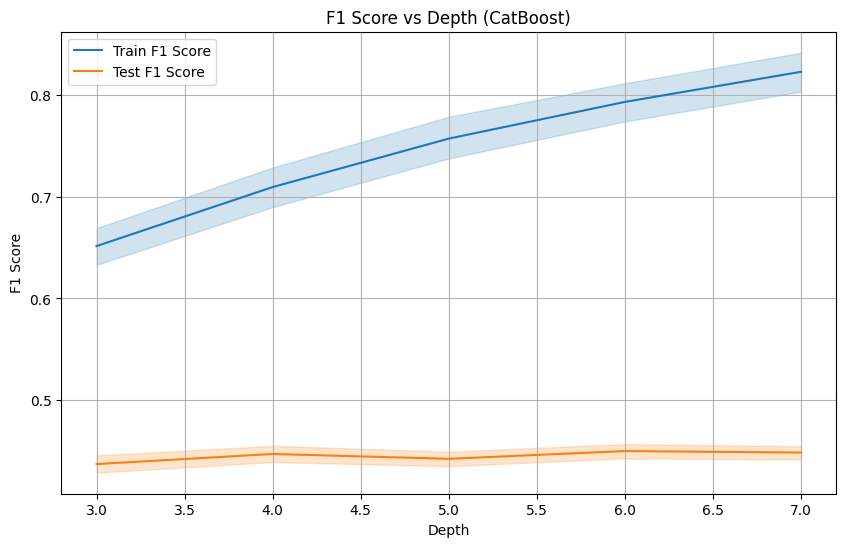

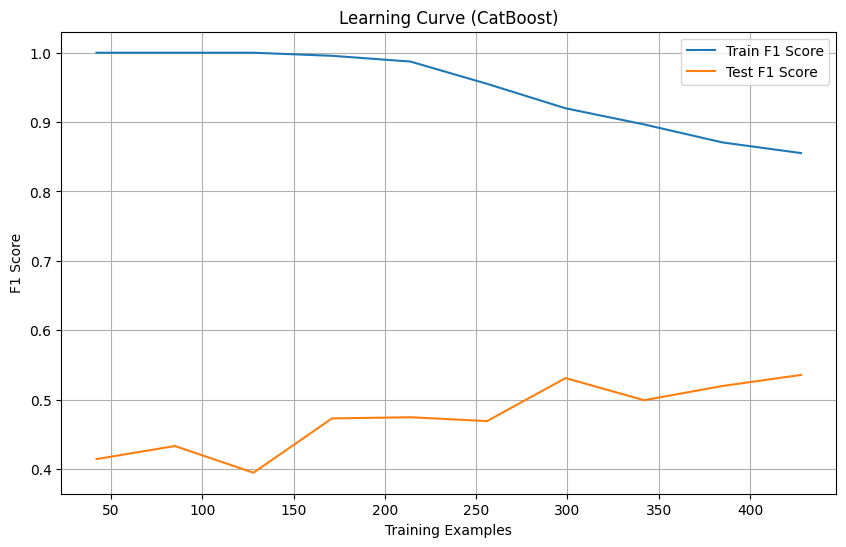

In [28]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

from catboost import CatBoostClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', CatBoostClassifier(random_state=42, verbose=0))
])

param_grid = [
    {
        'clf': [CatBoostClassifier(random_state=42, verbose=0)],
        'clf__depth': [3, 4, 5, 6, 7],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'clf__n_estimators': [50, 100, 150],
        'clf__l2_leaf_reg': [1, 3, 5, 7],
        'clf__min_data_in_leaf': [1, 2, 5],
        'clf__class_weights': [[1, 1], class_weights]
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_s_magistr, y_train_s_magistr)

y_pred = grid_search.predict(X_test_s_magistr)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/catboost_model_s_magistr.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_s_magistr, y_pred))

save_dir = 'catboost/s_magistr'
os.makedirs(save_dir, exist_ok=True)

cm = confusion_matrix(y_test_s_magistr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_catboost.png"))
plt.show()

importances = best_model.named_steps['clf'].feature_importances_
features = X_train_s_magistr.columns
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances)

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__depth',
    'mean_train_score',
    'mean_test_score'
]].copy()

results_filtered['param_clf__depth'] = pd.to_numeric(results_filtered['param_clf__depth'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Depth (CatBoost)')
plt.xlabel('Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_depth_catboost.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_magistr,
    y=y_train_s_magistr,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (CatBoost)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_catboost.png"))
plt.show()

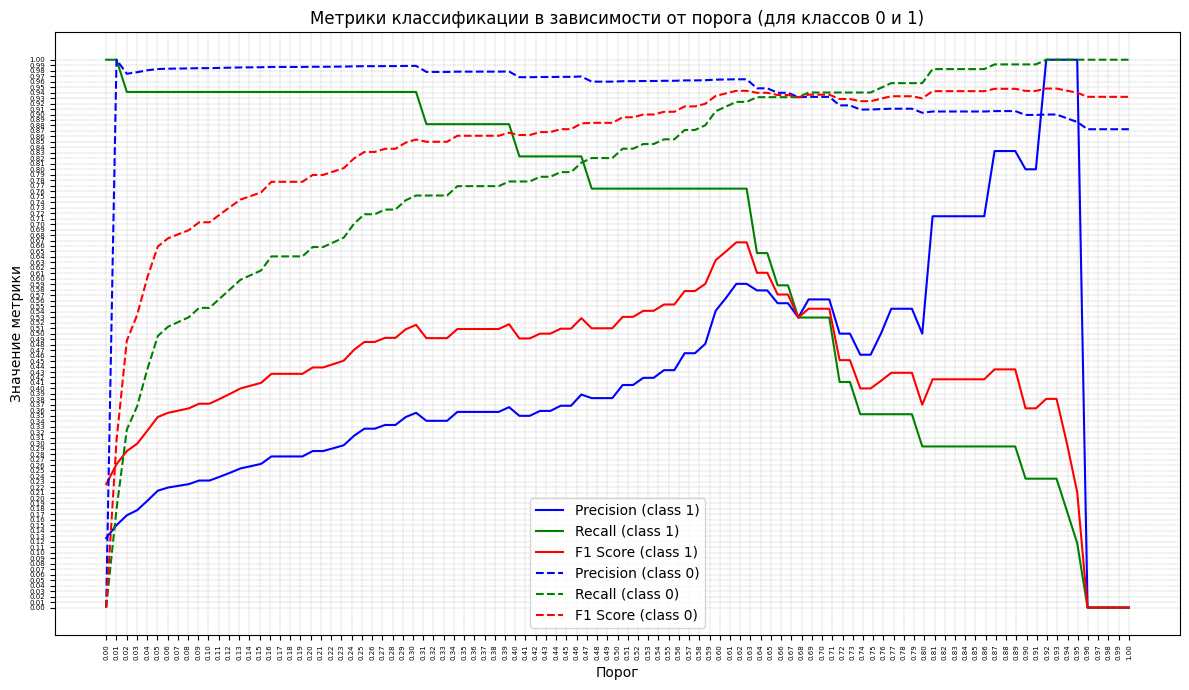

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_s_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))

save_dir = 'catboost/s_magistr'
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

# Сохраняем график
plt.savefig(os.path.join(save_dir, 'metrics_vs_threshold_catboost.png'), dpi=300)
plt.show()

In [30]:
classes = np.unique(y_train_s_bak_spec)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_s_bak_spec)
class_weights = [weights[0], weights[1]]

Лучшие параметры: {'clf': <catboost.core.CatBoostClassifier object at 0x000001EEF4319DE0>, 'clf__class_weights': [1, 1], 'clf__depth': 5, 'clf__l2_leaf_reg': 7, 'clf__learning_rate': 0.1, 'clf__min_data_in_leaf': 1, 'clf__n_estimators': 150}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x000001EEF489F280>)])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       271
           1       0.81      0.73      0.77        52

    accuracy                           0.93       323
   macro avg       0.88      0.85      0.86       323
weighted avg       0.93      0.93      0.93       323



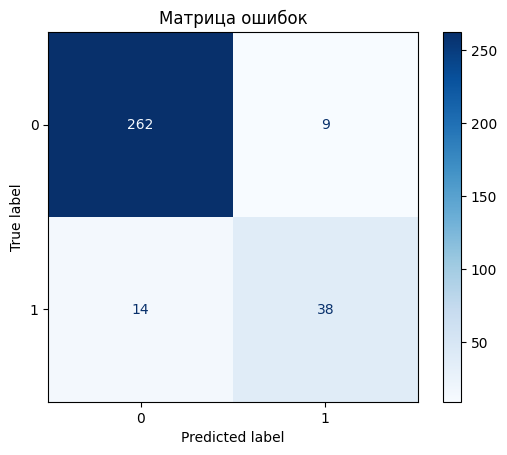


Feature Importances:
                                            feature  importance
10                          Общее количество долгов   29.863663
39                      Позиция студента в рейтинге   27.962721
1                            Cумма баллов испытаний    8.499027
3                           Балл за инд. достижения    5.308377
21                                       Специалист    4.368582
8                  Полных лет на момент поступления    2.917593
33                            Код направления 1: 11    2.168308
11                                 fromEkaterinburg    2.064502
25                                              СПО    1.728165
7                                               Пол    1.701961
37                             Код направления 3: 3    1.596394
0                                         Приоритет    1.454318
34                            Код направления 1: 27    1.383133
16                                    Целевая квота    1.218922
9                 

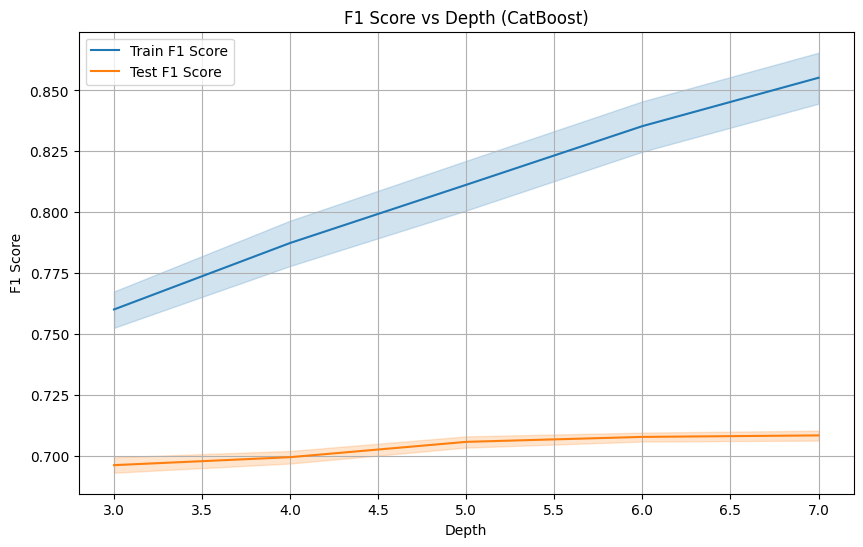

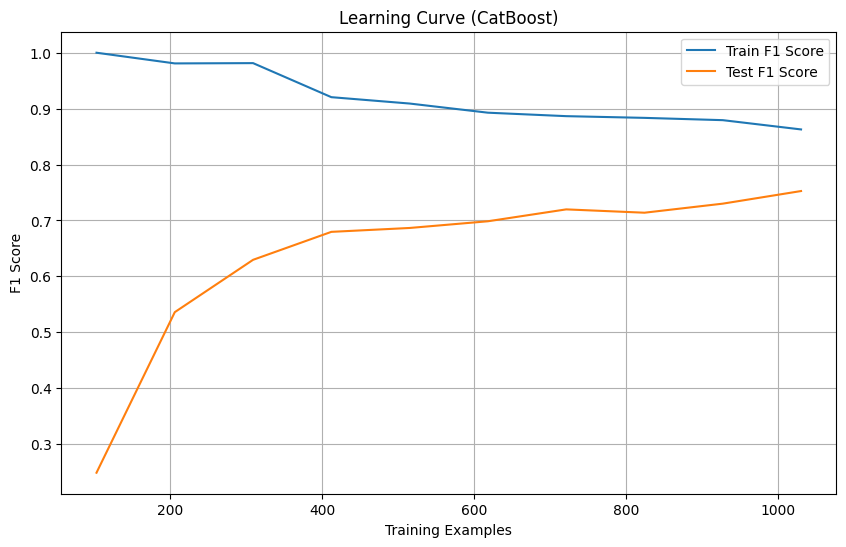

In [31]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

from catboost import CatBoostClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', CatBoostClassifier(random_state=42, verbose=0))
])

param_grid = [
    {
        'clf': [CatBoostClassifier(random_state=42, verbose=0)],
        'clf__depth': [3, 4, 5, 6, 7],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'clf__n_estimators': [50, 100, 150],
        'clf__l2_leaf_reg': [1, 3, 5, 7],
        'clf__min_data_in_leaf': [1, 2, 5],
        'clf__class_weights': [[1, 1], class_weights]
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_s_bak_spec, y_train_s_bak_spec)

y_pred = grid_search.predict(X_test_s_bak_spec)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/catboost_model_s_bak_spec.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_s_bak_spec, y_pred))

save_dir = 'catboost/s_bak_spec'
os.makedirs(save_dir, exist_ok=True)

cm = confusion_matrix(y_test_s_bak_spec, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_catboost.png"))
plt.show()

importances = best_model.named_steps['clf'].feature_importances_
features = X_train_s_bak_spec.columns
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances)

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__depth',
    'mean_train_score',
    'mean_test_score'
]].copy()

results_filtered['param_clf__depth'] = pd.to_numeric(results_filtered['param_clf__depth'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Depth (CatBoost)')
plt.xlabel('Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_depth_catboost.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_bak_spec,
    y=y_train_s_bak_spec,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (CatBoost)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_catboost.png"))
plt.show()

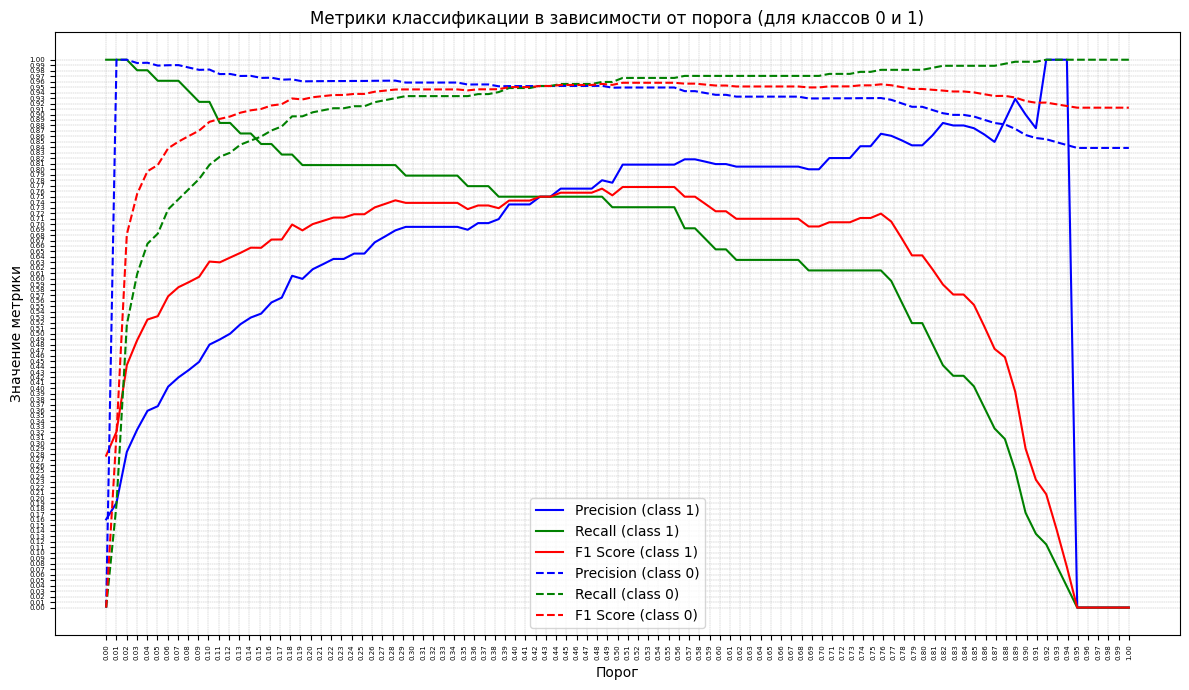

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_s_bak_spec)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))

save_dir = 'catboost/s_bak_spec'
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'metrics_vs_threshold_catboost.png'), dpi=300)
plt.show()

In [33]:
classes = np.unique(y_train_c1_magistr)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_c1_magistr)
class_weights = [weights[0], weights[1]]

Лучшие параметры: {'clf': <catboost.core.CatBoostClassifier object at 0x000001EEF64ACDC0>, 'clf__class_weights': [np.float64(0.589010989010989), np.float64(3.308641975308642)], 'clf__depth': 4, 'clf__l2_leaf_reg': 5, 'clf__learning_rate': 0.01, 'clf__min_data_in_leaf': 1, 'clf__n_estimators': 50}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x000001EEF6D58400>)])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.91      0.67      0.77       117
           1       0.19      0.53      0.28        17

    accuracy                           0.65       134
   macro avg       0.55      0.60      0.52       134
weighted avg       0.82      0.65      0.71       134



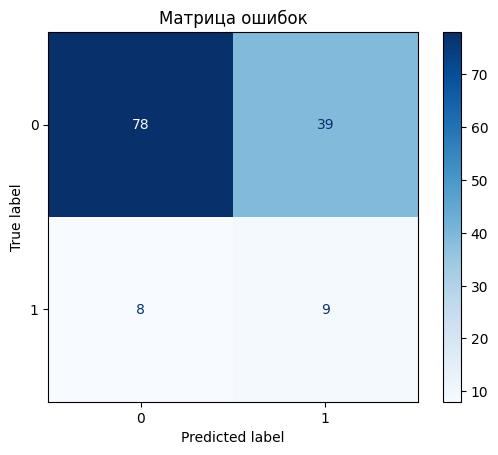


Feature Importances:
                                            feature  importance
7                  Полных лет на момент поступления   25.411381
1                            Cумма баллов испытаний   19.727379
4                             Нуждается в общежитии    8.745609
8                                  fromEkaterinburg    8.361919
9                              fromSverdlovskRegion    8.035214
0                                         Приоритет    7.970288
2                           Балл за инд. достижения    7.267664
30                            Код направления 1: 27    4.006052
6                                               Пол    2.162056
10                          Human Development Index    2.136894
29                            Код направления 1: 11    1.854760
34                             Код направления 3: 4    1.267973
32                             Код направления 3: 2    1.036321
5                      Иностранный абитуриент (МОН)    0.874904
28                

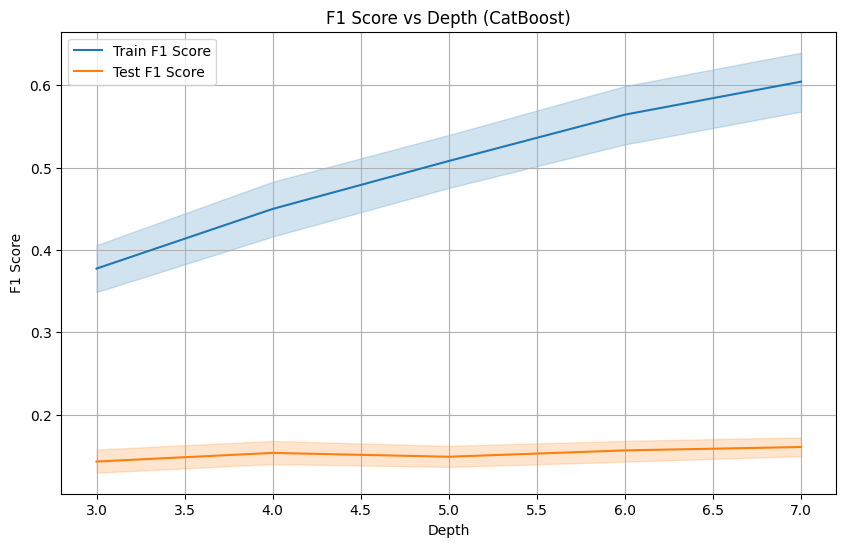

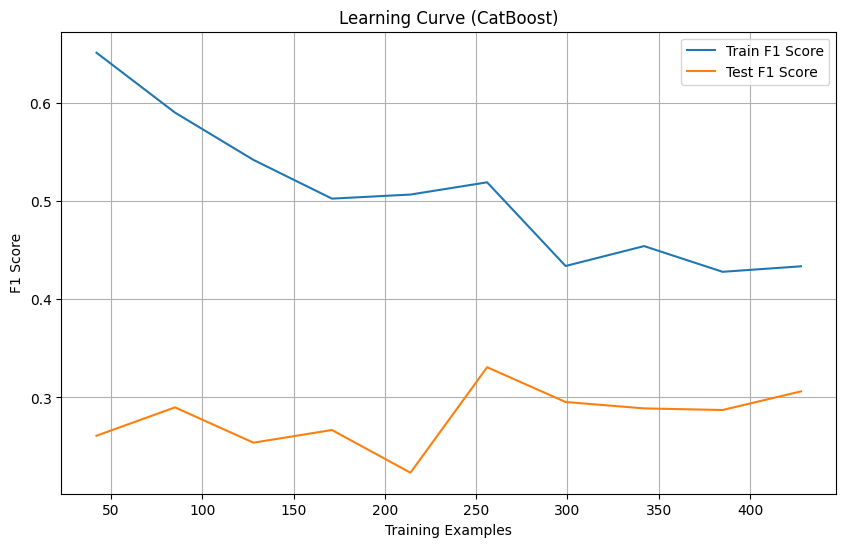

In [34]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

from catboost import CatBoostClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', CatBoostClassifier(random_state=42, verbose=0))
])

param_grid = [
    {
        'clf': [CatBoostClassifier(random_state=42, verbose=0)],
        'clf__depth': [3, 4, 5, 6, 7],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'clf__n_estimators': [50, 100, 150],
        'clf__l2_leaf_reg': [1, 3, 5, 7],
        'clf__min_data_in_leaf': [1, 2, 5],
        'clf__class_weights': [[1, 1], class_weights]
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_c1_magistr, y_train_c1_magistr)

y_pred = grid_search.predict(X_test_c1_magistr)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/catboost_model_c1_magistr.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_c1_magistr, y_pred))

save_dir = 'catboost/c1_magistr'
os.makedirs(save_dir, exist_ok=True)

cm = confusion_matrix(y_test_c1_magistr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_catboost.png"))
plt.show()

importances = best_model.named_steps['clf'].feature_importances_
features = X_train_c1_magistr.columns
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances)

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__depth',
    'mean_train_score',
    'mean_test_score'
]].copy()

results_filtered['param_clf__depth'] = pd.to_numeric(results_filtered['param_clf__depth'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Depth (CatBoost)')
plt.xlabel('Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_depth_catboost.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_c1_magistr,
    y=y_train_c1_magistr,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (CatBoost)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_catboost.png"))
plt.show()

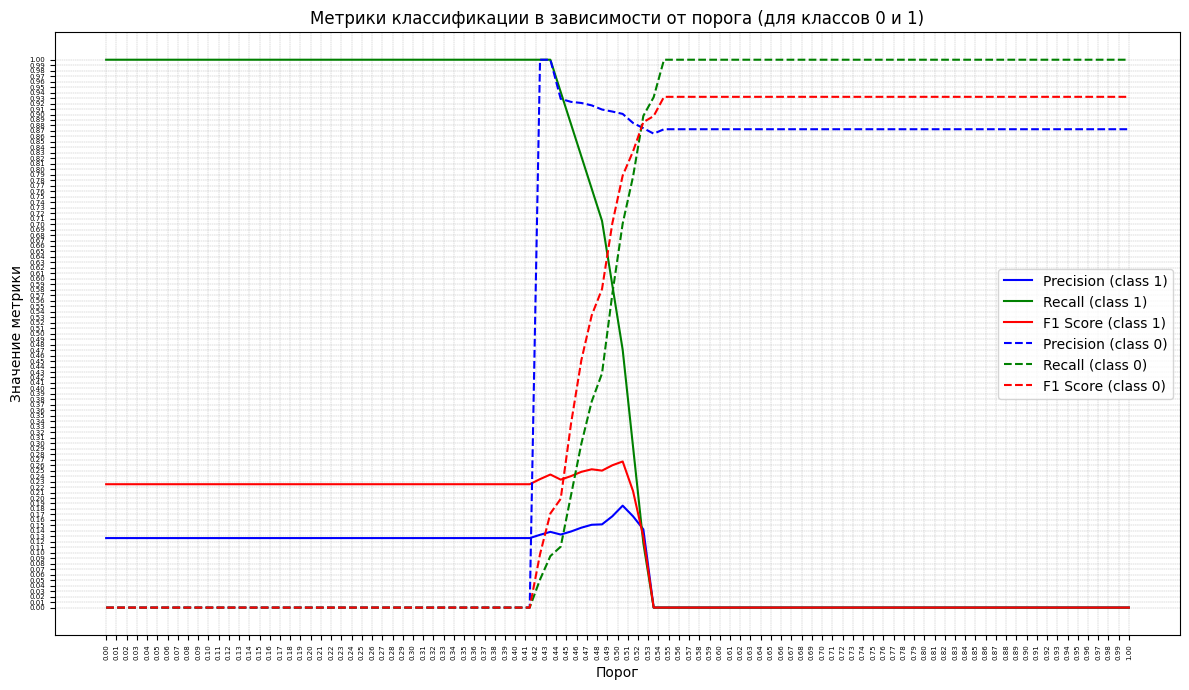

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_c1_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))

save_dir = 'catboost/c1_magistr'
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'metrics_vs_threshold_catboost.png'), dpi=300)
plt.show()

In [36]:
classes = np.unique(y_train_c1_bak_spec)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_c1_bak_spec)
class_weights = [weights[0], weights[1]]

Лучшие параметры: {'clf': <catboost.core.CatBoostClassifier object at 0x000001EEF6DCB0A0>, 'clf__class_weights': [np.float64(0.6086956521739131), np.float64(2.8)], 'clf__depth': 4, 'clf__l2_leaf_reg': 1, 'clf__learning_rate': 0.05, 'clf__min_data_in_leaf': 1, 'clf__n_estimators': 150}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x000001EEF3A2CAF0>)])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.93      0.78      0.85       271
           1       0.39      0.71      0.50        52

    accuracy                           0.77       323
   macro avg       0.66      0.75      0.68       323
weighted avg       0.85      0.77      0.79       323



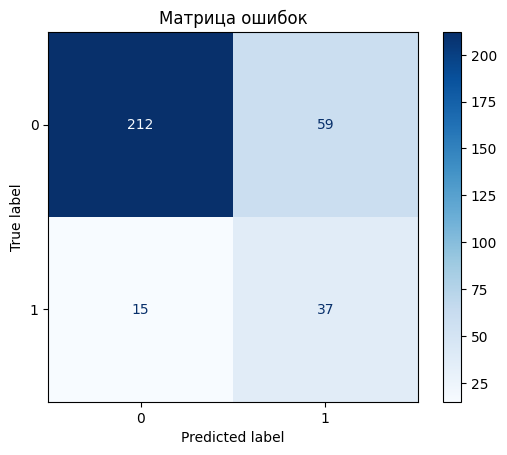


Feature Importances:
                                            feature  importance
8                  Полных лет на момент поступления   20.395347
1                            Cумма баллов испытаний   16.504257
3                           Балл за инд. достижения   15.308437
19                                       Специалист    4.889680
22                                 Профильная Школа    4.858686
32                            Код направления 1: 27    4.420391
17                                          Заочная    3.356793
0                                         Приоритет    3.179174
11                          Human Development Index    3.013538
14                                    Целевая квота    2.674331
35                             Код направления 3: 3    2.504270
16  олимпиада из перечня, утвержденного МОН РФ (ОШ)    2.129504
4                                          Контракт    2.119964
30                            Код направления 1: 10    1.803907
23                

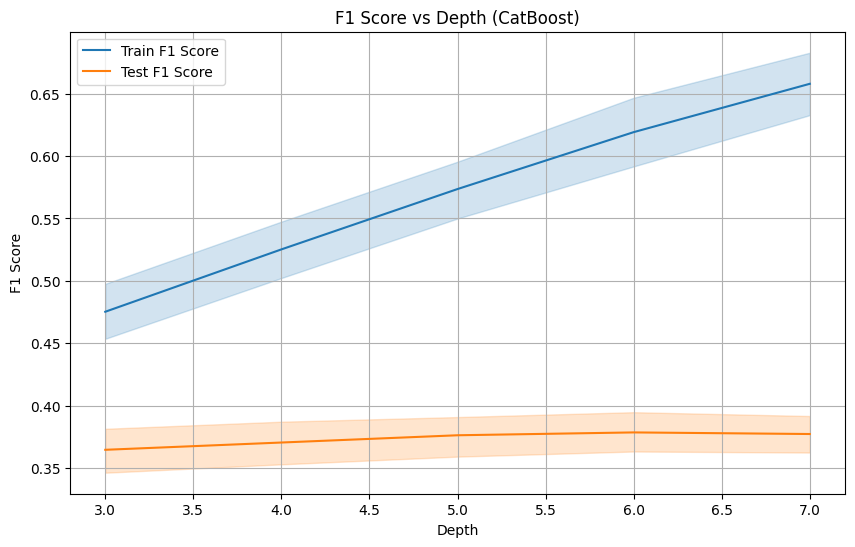

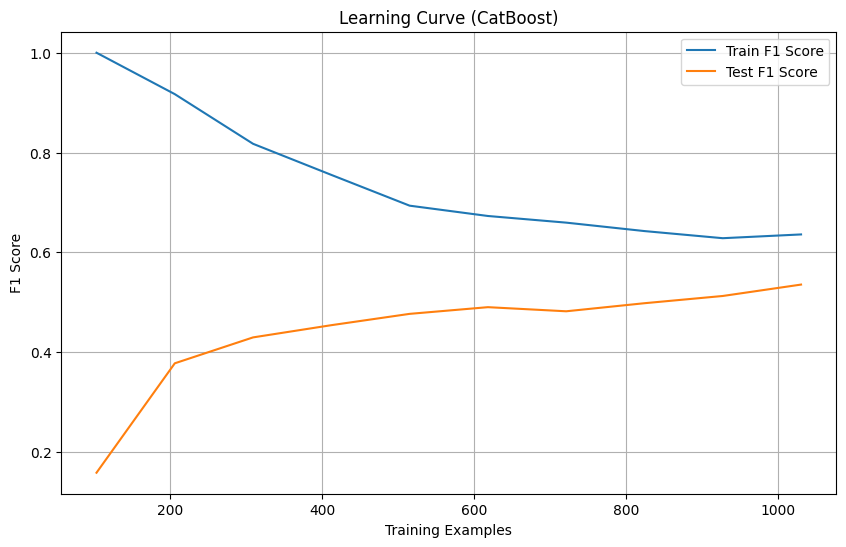

In [37]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

from catboost import CatBoostClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', CatBoostClassifier(random_state=42, verbose=0))
])

param_grid = [
    {
        'clf': [CatBoostClassifier(random_state=42, verbose=0)],
        'clf__depth': [3, 4, 5, 6, 7],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'clf__n_estimators': [50, 100, 150],
        'clf__l2_leaf_reg': [1, 3, 5, 7],
        'clf__min_data_in_leaf': [1, 2, 5],
        'clf__class_weights': [[1, 1], class_weights]
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_c1_bak_spec, y_train_c1_bak_spec)

y_pred = grid_search.predict(X_test_c1_bak_spec)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/catboost_model_c1_bak_spec.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_c1_bak_spec, y_pred))

save_dir = 'catboost/c1_bak_spec'
os.makedirs(save_dir, exist_ok=True)

cm = confusion_matrix(y_test_c1_bak_spec, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_catboost.png"))
plt.show()

importances = best_model.named_steps['clf'].feature_importances_
features = X_train_c1_bak_spec.columns
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances)

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__depth',
    'mean_train_score',
    'mean_test_score'
]].copy()

results_filtered['param_clf__depth'] = pd.to_numeric(results_filtered['param_clf__depth'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Depth (CatBoost)')
plt.xlabel('Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_depth_catboost.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_c1_bak_spec,
    y=y_train_c1_bak_spec,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (CatBoost)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_catboost.png"))
plt.show()

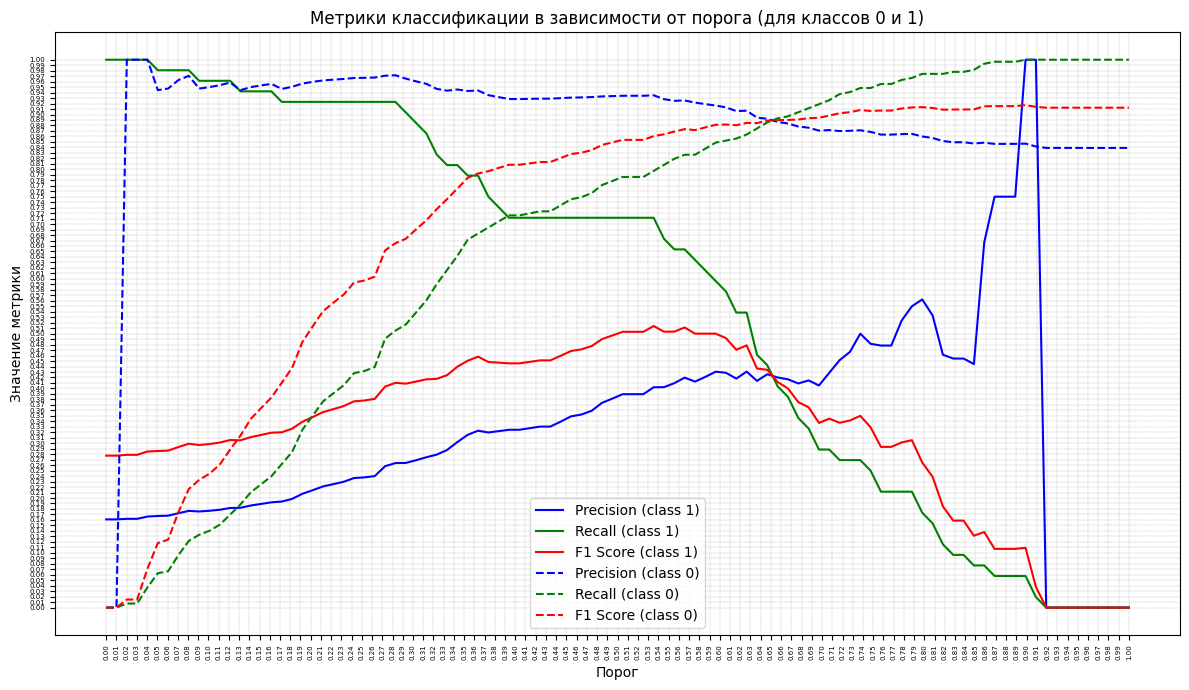

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_c1_bak_spec)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))

save_dir = 'catboost/c1_bak_spec'
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'metrics_vs_threshold_catboost.png'), dpi=300)
plt.show()